In [ ]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

metrics_files = sorted(Path(r"..\models").glob("*_metrics.json"))
accuracies = {}
f1_data = {}
precision_data = {}
recall_data = {}
support_data = {}

for p in metrics_files:
    print("Loaded", p.name + '...')
    name = p.name.rsplit("_metrics.json", 1)[0]
    m = json.load(open(p, "r", encoding="utf8"))
    accuracies[name] = m.get("accuracy", None)
    for cls in ("negative", "neutral", "positive", "macro avg", "weighted avg"):
        f1_data.setdefault(cls, {})[name] = m.get(cls, {}).get("f1-score", np.nan)
        precision_data.setdefault(cls, {})[name] = m.get(cls, {}).get("precision", np.nan)
        recall_data.setdefault(cls, {})[name] = m.get(cls, {}).get("recall", np.nan)
        support_data.setdefault(cls, {})[name] = m.get(cls, {}).get("support", np.nan)

Loaded lstm_metrics.json...
Loaded naive_bayes_metrics.json...
Loaded svm_metrics.json...


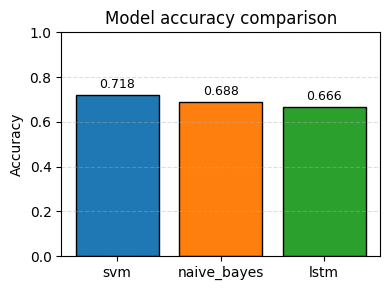

In [2]:
acc_df = pd.Series(accuracies, name="accuracy").sort_values(ascending=False)
plt.figure(figsize=(4, 3))
models = acc_df.index.tolist()
vals = acc_df.values
cmap = plt.get_cmap("tab10")
colors = [cmap(i % 10) for i in range(len(models))]
bars = plt.bar(models, vals, color=colors, edgecolor="black")
plt.ylim(0, 1)
plt.title("Model accuracy comparison")
plt.ylabel("Accuracy")
plt.grid(axis="y", linestyle="--", alpha=0.4)
for b, v in zip(bars, vals):
    plt.text(b.get_x() + b.get_width() / 2, v + 0.02, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

In [3]:
def plot(df, title):
    plt.figure(figsize=(6, 3))
    classes = df.index.tolist()
    models = df.columns.tolist()
    n_models = len(models)
    x = np.arange(len(classes))
    width = 0.8 / max(1, n_models)
    for i, model in enumerate(models):
        vals = df.map(lambda x: 0.02 if x < 0.02 else x)[model].astype(float).values
        plt.bar(x + (i - (n_models - 1) / 2) * width, vals, width=width,
                label=model, color=cmap(i % 10), edgecolor="black")
    plt.xticks(x, classes)
    plt.ylabel(title)
    plt.title(f"Per-class {title} by model")
    plt.legend(title="Model")
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def df_t(data):
    df = pd.DataFrame(data).T
    df = df[acc_df.index.tolist()]
    return df

In [4]:
f1_df = df_t(f1_data)
f1_df

,svm,naive_bayes,lstm
negative,0.778658,0.763895,0.720779
neutral,0.410372,0.004082,0.349493
positive,0.797030,0.767347,0.752542
macro avg,0.662020,0.511775,0.607605
weighted avg,0.711106,0.610490,0.658073


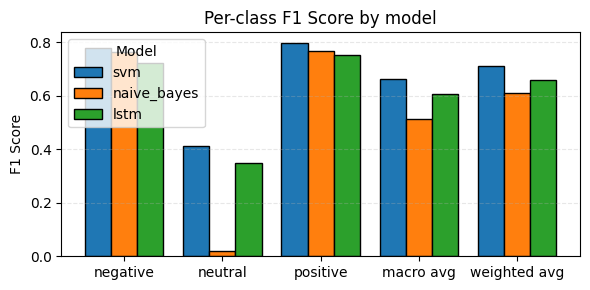

In [5]:
plot(f1_df, "F1 Score")

In [6]:
prec_df = df_t(precision_data)
prec_df

,svm,naive_bayes,lstm
negative,0.767708,0.686007,0.727869
neutral,0.457286,1.000000,0.389447
positive,0.772553,0.689487,0.714811
macro avg,0.665849,0.791831,0.610709
weighted avg,0.706434,0.751401,0.653595


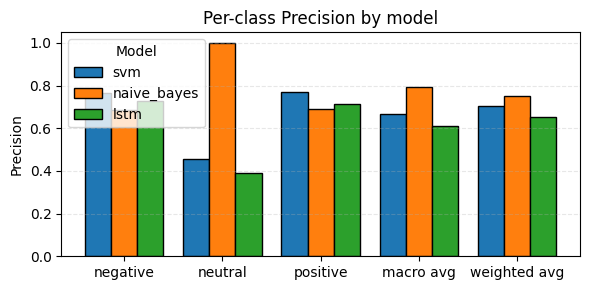

In [7]:
plot(prec_df, "Precision")

In [8]:
rec_df = df_t(recall_data)
rec_df

,svm,naive_bayes,lstm
negative,0.789925,0.861736,0.713826
neutral,0.372188,0.002045,0.316973
positive,0.823108,0.865031,0.794479
macro avg,0.661740,0.576271,0.608426
weighted avg,0.718333,0.687917,0.665833


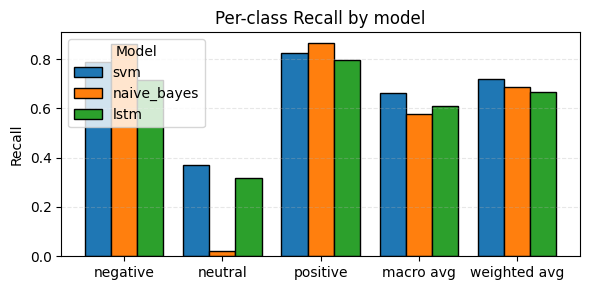

In [9]:
plot(rec_df, "Recall")

In [10]:
sup_df = df_t(support_data)
sup_df

,svm,naive_bayes,lstm
negative,933.0,933.0,933.0
neutral,489.0,489.0,489.0
positive,978.0,978.0,978.0
macro avg,2400.0,2400.0,2400.0
weighted avg,2400.0,2400.0,2400.0


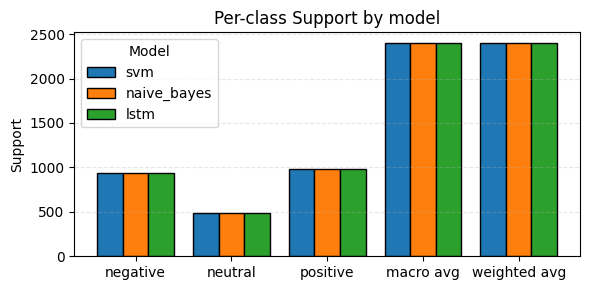

In [11]:
plot(sup_df, "Support")

In [12]:
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

print("Reading csv...")
df = pd.read_csv(r"..\data\processed\train_clean.csv")
df_en = df[df['language'] == 'en']
df_es = df[df['language'] == 'es']

X_en = df_en['text']
y_en = df_en['sentiment']
X_es = df_es['text']
y_es = df_es['sentiment']

print("Vectorizing...")
vectorizer = TfidfVectorizer()
X_en_vec = vectorizer.fit_transform(X_en)
X_es_vec = vectorizer.transform(X_es)

print("Fitting...")
nb_model = MultinomialNB()
nb_model.fit(X_en_vec, y_en)

print("Predicting...")
y_pred_en = nb_model.predict(X_en_vec)
y_pred_es = nb_model.predict(X_es_vec)

Reading csv...
Vectorizing...
Fitting...
Predicting...


In [13]:
report_en = classification_report(y_en, y_pred_en, output_dict=True, zero_division=1)
df_en = pd.DataFrame(report_en).transpose()
df_en

,precision,recall,f1-score,support
negative,0.718341,0.918107,0.806031,9317.000000
neutral,1.000000,0.003278,0.006535,4881.000000
positive,0.735145,0.906445,0.811858,9759.000000
accuracy,0.726969,0.726969,0.726969,0.726969
macro avg,0.817829,0.609277,0.541474,23957.000000
weighted avg,0.782571,0.726969,0.645515,23957.000000


In [14]:
report_es = classification_report(y_es, y_pred_es, output_dict=True, zero_division=1)
df_es = pd.DataFrame(report_es).transpose()
df_es

,precision,recall,f1-score,support
negative,1.000000,0.333333,0.500000,3.000000
neutral,1.000000,0.000000,0.000000,5.000000
positive,0.695652,1.000000,0.820513,16.000000
accuracy,0.708333,0.708333,0.708333,0.708333
macro avg,0.898551,0.444444,0.440171,24.000000
weighted avg,0.797101,0.708333,0.609509,24.000000


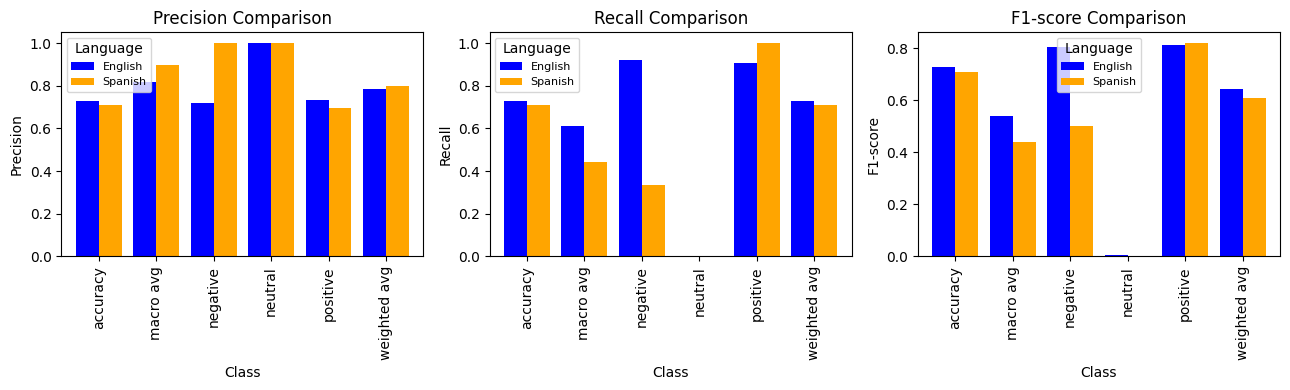

In [17]:
df_en['language'] = 'English'
df_es['language'] = 'Spanish'
df = pd.concat([df_en, df_es])
df = df.reset_index().rename(columns={'index': 'class'})
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics):
    ax = axes[i]
    df_pivot = df.pivot_table(index='class', columns='language', values=metric)
    df_pivot.plot(kind='bar', ax=ax, color=['blue', 'orange'], width=0.8)
    ax.set_title(f'{metric.capitalize()} Comparison')
    ax.set_xlabel('Class')
    ax.set_ylabel(metric.capitalize())
    ax.legend(title='Language', fontsize=8)
plt.tight_layout()
plt.show()